# Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from scipy.signal import find_peaks
import scipy.signal.windows as win
import scipy as sp
import warnings
import re
from ipywidgets import interact,widgets
from scipy.optimize import curve_fit
import glob

In [2]:
#plt.rcParams["text.usetex"] = False
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "stix"#"dejavuserif" 
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams['font.size'] = 12; plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12; plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12; plt.rcParams['ytick.labelsize'] = 12 # Tamanho da fonte dos números do eixo y
plt.rcParams['svg.fonttype'] = 'none'

# Functions

In [ ]:
# Función para extraer la temperatura del nombre del archivo
c = 0.299792458 # speed of light mm/ps
def extraer_temperatura(nombre_archivo):
    match = re.search(r'(\d+\.\d+|\d+)K', nombre_archivo)
    if match:
        return float(match.group(1))
    else:
        return None
    
def apply_window(params):
    """
    Aplica una ventana de scipy a una señal.

    Parámetros:
    - params (list): Lista con los siguientes elementos:
      1. Nombre de la ventana (str).
      2. Tamaño de la ventana (M) (int).
      3. Parámetros adicionales de la ventana (opcional).

    Retorna:
    - ventana (array): La ventana calculada.
    """
    try:
        # Extrae el nombre de la ventana y el tamaño M de la lista
        window_name = params[0]
        M = params[1]
        extra_params = params[2:]  # Parámetros adicionales para la ventana

        # Obtiene la función de ventana a partir del nombre
        window_func = getattr(win, window_name)
        
        # Aplica la ventana con M como primer argumento y los parámetros adicionales
        window = window_func(M, *extra_params)
        return window
    except AttributeError:
        raise ValueError(f"Ventana '{window_name}' no está disponible en scipy.signal.windows.")
    except TypeError as e:
        raise ValueError(f"Error al pasar los parámetros a la ventana: {e}")

def loadData(name):
    # Leer el archivo CSV
    nombre_archivo = name
    df = pd.read_csv(nombre_archivo)

    # Asignar cada columna a una variable
    Temp = df['Temp'].values
    ep_inf = df['ep_inf'].values
    ep_s = df['ep_s'].values
    nu_to = df['nu_to'].values
    Gamma = df['Gamma'].values
    nu_p = df['nu_p'].values
    gamma = df['gamma'].values

    return Temp, ep_inf,ep_s,nu_to,Gamma,nu_p,gamma


def epsilon_drude(nu,ep_inf,ep_s,nu_to,Gamma,nu_p,gamma):

    return ep_inf+(ep_s-ep_inf)*nu_to**2/(nu_to**2-nu**2-1j*nu*Gamma)-nu_p**2/(nu**2+1j*nu*gamma)

def epsilon(nu,ep_inf,ep_s,nu_to,Gamma):

    return ep_inf+(ep_s-ep_inf)*nu_to**2/(nu_to**2-nu**2-1j*nu*Gamma)

def T_crit(T,a,Tcrit):

    return a*(T-Tcrit)**0.5

def epsilonboth_drude(nu,ep_inf,ep_s,nu_to,Gamma,nu_p,gamma):
    N = len(nu)
    nu_real = nu[:N//2]
    nu_imag = nu[N//2:]
    y_real = np.real(epsilon_drude(nu_real, ep_inf,ep_s,nu_to,Gamma,nu_p,gamma))
    y_imag = np.imag(epsilon_drude(nu_imag, ep_inf,ep_s,nu_to,Gamma,nu_p,gamma))
    return np.hstack([y_real, y_imag])

def epsilonboth(nu,ep_inf,ep_s,nu_to,Gamma):
    N = len(nu)
    nu_real = nu[:N//2]
    nu_imag = nu[N//2:]
    y_real = np.real(epsilon(nu_real, ep_inf,ep_s,nu_to,Gamma))
    y_imag = np.imag(epsilon(nu_imag, ep_inf,ep_s,nu_to,Gamma))
    return np.hstack([y_real, y_imag])


def fit_complex_drude(x,y,p0=[]):

    #Return ep_inf,ep_s,nu_to,Gamma,nu_p,gamma
    yReal = np.real(y)
    yImag = np.imag(y)
    yBoth = np.hstack([yReal, yImag])
    #lim_inf = [0, 0, 0, 0.00000, 0.00000, 0.00000] # 0.77868 # 0.06% -> 0.54868[::-1] # 0.10% -> 0.28562
    #lim_sup = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf] # 1.29225

    bounds = ([0, 0, 0.2,0,0,0], [100, 100, 1.2, 1.2,np.inf,1.2])
    if not p0 :
        poptBoth, pcovBoth = curve_fit(epsilonboth_drude, np.hstack([x, x]), yBoth,bounds=bounds,maxfev=5000)
        return poptBoth

    else:
        poptBoth, pcovBoth = curve_fit(epsilonboth_drude, np.hstack([x, x]), yBoth,p0=p0,bounds=bounds,maxfev=10000)
        return poptBoth

def fit_complex(x,y,p0):

    #Return ep_inf,ep_s,nu_to,Gamma,nu_p,gamma
    yReal = np.real(y)
    yImag = np.imag(y)
    yBoth = np.hstack([yReal, yImag])
    #lim_inf = [0, 0, 0, 0.00000, 0.00000, 0.00000] # 0.77868 # 0.06% -> 0.54868[::-1] # 0.10% -> 0.28562
    #lim_sup = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf] # 1.29225
    if not p0 :
        poptBoth, pcovBoth = curve_fit(epsilonboth, np.hstack([x, x]), yBoth,maxfev=5000)
        return poptBoth

    else:
        poptBoth, pcovBoth = curve_fit(epsilonboth, np.hstack([x, x]), yBoth,maxfev=5000)
        return poptBoth

def FourierT(f,N):
    return np.conj(sp.fft.fft(f.values,n=N))

def agrupar_por_rango_temperatura(archivos_por_temp, rangos):
    archivos_por_rango = {rango: [] for rango in rangos}
    for temp, archivos in archivos_por_temp.items():
        for rango in rangos:
            if rango[0] <= temp < rango[1]:  # Verifica si la temperatura está dentro del rango
                archivos_por_rango[rango].extend(archivos)
                break  # Detiene el ciclo una vez que encuentra el rango correcto

    archivos_por_rango  = {k: v for k, v in archivos_por_rango .items() if v}
    
    return archivos_por_rango

def generar_rangos(min_temp, max_temp, paso):
    rangos = []
    if paso == 0:
        return None
    else:
        for i in np.arange(min_temp, max_temp+paso, paso):
            rangos.append((i, i + paso))
        return rangos

# Función para procesar archivos .dat
def convert_dats(carpeta,N):
    nueva_carpeta = os.path.join(carpeta, 'carpeta1')
    os.makedirs(nueva_carpeta, exist_ok=True)
    
    archivos = [archivo for archivo in os.listdir(carpeta) if archivo.endswith('.dat')]
    
    # Agrupar archivos por temperatura
    archivos_por_temp = {}
    temperaturas = []

    for archivo in archivos:
        temp = extraer_temperatura(archivo)
        if temp is not None:
            temperaturas.append(temp)
            archivos_por_temp.setdefault(temp, []).append(archivo)

    if not temperaturas:
        print("No se encontraron temperaturas en los archivos.")
        return
    
    archivos_por_temp = dict(sorted(archivos_por_temp.items()))
    #FIN AGRUPACION ARCHIVOS POR TEMP
    
    min_temp = min(temperaturas)
    max_temp = max(temperaturas)

    # Generar rangos de temperatura desde la mínima hasta la máxima, de 10 en 10
    rangos_temperatura = generar_rangos(min_temp, max_temp, N)

    if rangos_temperatura is None:
        archivos_por_rango = archivos_por_temp
    else: 
    # Agrupar archivos por rango de temperatura
        archivos_por_rango = agrupar_por_rango_temperatura(archivos_por_temp, rangos_temperatura)


    # Procesar archivos por cada temperatura
    for rango, lista_archivos in archivos_por_rango.items():
        try:
            # Inicializar variables de acumulación
            suma_col1 = None
            suma_col2 = None
            n_archivos = len(lista_archivos)
            
            # Iterar sobre los archivos con la misma temperatura
            temps_arch = []

            for archivo in lista_archivos:
                temps_arch.append(extraer_temperatura(archivo))
                df = pd.read_csv(os.path.join(carpeta, archivo), delim_whitespace=True)
                
                # Acumular las columnas
                if suma_col1 is None:
                    suma_col1 = df['pos']
                    suma_col2 = df['X']
                else:
                    suma_col1 += df['pos']
                    suma_col2 += df['X']
            
            # Calcular el promedio
            promedio_col1 = suma_col1 / n_archivos * (2/c)
            promedio_col2 = suma_col2 / n_archivos
            
            # Crear un DataFrame con los promedios
            df_promedio = pd.DataFrame({'pos': promedio_col1, 'X': promedio_col2})
            mean_temp = (max(temps_arch)+min(temps_arch))/2
            # Guardar el archivo resultante en la nueva carpeta
            archivo_salida = os.path.join(nueva_carpeta, f'Average_{round(mean_temp,2)}K.dat')
            df_promedio.to_csv(archivo_salida, index=False, sep=' ')
            print(f"Archivo {archivo_salida} generado en {nueva_carpeta}.")
        
        except Exception as e:
            print(f"Error al procesar los archivos con temperatura {round(mean_temp,2)}: {e}")


def getFilterdata(path_signal,right,left):

    df1 = pd.read_csv(path_signal, delim_whitespace=True)
    df1 = df1.loc[(df1.iloc[:, 0] >= left) & (df1.iloc[:, 0] <=right)]
    return df1['pos']* (2/c) ,df1['X']


def getSignal(path_signal,right,left):

    df1 = pd.read_csv(path_signal, delim_whitespace=True)
    df1 = df1.loc[(df1.iloc[:, 0] >= left) & (df1.iloc[:, 0] <=right)]
    return df1['X']

def getSignalWindowed(path_signal,path_ref,left,right_signal,right_subs,params_window = []):
    '''
    Función encargada de aplicar una ventana definidica poro params_window
    a una señal definida en path_signal y path_ref. El método que se usa es desplazar el substrato hasta el 
    maximo de la señal. Luego, se completa la señal del substrado con cero padding y finalmente, ambas se
    centralizan con la ventana. 
    Parameters
    ----------------
    path_signal: string.
    path_ref: string
    left:float
    '''
    if not params_window :
        # Cuando no se usara ventana.
        return y,y_substrate
    else:
        # Obtencion de la señal que pasa por el film.
        y = getSignal(path_signal,right_signal,left)
        # Obtención del substrato.
        y_substrate = getSignal(path_ref,right_subs,left)
        #PROPIEDADES DE LAS SEÑALES.
        idx_max_signal = np.argmax(y)
        idx_max_substrate = np.argmax(y_substrate)
        len_y = len(y)
        len_y_substrate = len(y_substrate)
        #Phase
        desplazamiento_signal = idx_max_signal - idx_max_substrate
        #Desplazando substrato hacia la señal.
        y_substrate_desplazada = pd.Series(np.roll(y_substrate, desplazamiento_signal))
        diferencia = len_y - len_y_substrate
        if diferencia==0:

            y_substrate_padding = y_substrate_desplazada

        else:

            y_substrate_padding = pd.Series(np.pad(y_substrate_desplazada, (0, diferencia), 'constant', constant_values=0))

        #DEFINIENDO PARAMETROS DE LA VENTANA
        params_window.insert(1,len_y)
        ventana = apply_window(params_window)
        idx_max_window = np.argmax(ventana)
        desp_hacia_ventana = idx_max_window - idx_max_signal
        # MOVIENDO TANTO LA SEÑAL COMO 
        y_desplazada_max = np.roll(y,desp_hacia_ventana)
        y_substrate_padding_max = np.roll(y_substrate_padding,desp_hacia_ventana)

        return desplazamiento_signal, y_desplazada_max, y_substrate_padding_max, ventana
       

# MUESTRA PbTe

In [4]:
# bis = [0.02,0.03,0.06,0.07,0.1,0.15] # Porcentaje de Bismuto.

delta_ls = {"20-20": 0.446- 0.360, # Substrato - mostra. (Mostra = substrato + FILM ) FILM -> OBJETO DE ESTUDIO. BaF2
}  # SINN BISMUTO.

sample = "20-20"
d = 0.0016

In [5]:
carpeta = rf'C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20'

carpeta_ref = rf'C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\substrate\20-20'

archivos_dat = glob.glob(os.path.join(os.path.join(carpeta,'carpeta1'), '*.dat'))


archivos_dat_ref = glob.glob(os.path.join(os.path.join(carpeta_ref,'carpeta1'), '*.dat'))

# Elimina cada archivo
for archivo in archivos_dat:
    os.remove(archivo)
    #print(f'Archivo {archivo} eliminado.')

for archivo in archivos_dat_ref:
    os.remove(archivo)
    #print(f'Archivo {archivo} eliminado.')



warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
N = 0 # Variable para agrupar datos de temperatura

convert_dats(carpeta,N)
convert_dats(carpeta_ref,N)

Archivo C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1\Average_10.0K.dat generado en C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1.
Archivo C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1\Average_20.0K.dat generado en C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1.
Archivo C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1\Average_40.0K.dat generado en C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1.
Archivo C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1\Average_60.0K.dat generado en C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1.
Archivo C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1\Average_80.0K.dat generado en C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1.
Archivo C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1\Average_100.0K.dat generado en C:\Users\usuario_trabajo\Desk

In [7]:
#path_analisis = r'C:\Users\usuario_trabajo\Desktop\physics\TESIS\20-20\20-20\carpeta1'
path_analisis = os.path.join(carpeta,'carpeta1')
path_analisis_ref = os.path.join(carpeta_ref,'carpeta1')

# Obtener lista de archivos .dat en la carpeta
archivos = os.listdir(path_analisis)
archivos2 = os.listdir(path_analisis_ref)

# Filtrar y ordenar los archivos por la temperatura
archivos_ordenados_s = sorted(
    archivos,
    key=lambda x: extraer_temperatura(x)
)

archivos_ordenados_ref = sorted(
    archivos2,
    key=lambda x: extraer_temperatura(x)
)

# Gauge

In [8]:
colors = plt.cm.jet(np.linspace(0, 1, len(archivos_ordenados_s)))[::-1]


In [9]:
def anim2(left,right_sample,right_subs,index,correc_subs,desv):
    
    f = plt.figure(figsize=(13, 10),dpi=200)

    N = 2**12

    global nk0, nk1, nk2
    nk0 = left
    nk1 = right_sample
    nk2 = right_subs

    path_signal = os.path.join(path_analisis,archivos_ordenados_s[int(index)])
    path_ref = os.path.join(path_analisis_ref ,archivos_ordenados_ref[int(index)])
    params_window = ['gaussian', desv]

    phase, y_signal_ventaneada, y_substrate_padding, ventana = getSignalWindowed(path_signal,path_ref,left,right_sample,right_subs,params_window)

    x,y = getFilterdata(path_signal,right_sample,left)
    print(x[1]-x[0])
    print(len(y))
    x_ref,y_ref = getFilterdata(path_ref,right_subs,left)

    # Datos substrate
    y_subs_ventana = pd.Series(y_substrate_padding*ventana)
    y_signal_ventaneada = pd.Series(y_signal_ventaneada*ventana)


    plt.subplot(321)
    plt.plot(x,y/max(y),'k',label='without window')
    plt.plot(x,ventana,'r',label='window')
    plt.plot(x,y_signal_ventaneada/max(y_signal_ventaneada),'o',color = colors[-int(index)],label='Signal + window')
    plt.title('Signal')
    plt.legend()

    plt.subplot(322)
    plt.plot(x_ref,y_ref/max(y_ref),'k',label='without window')
    plt.plot(x,ventana,'r',label='window')
    plt.plot(x,y_subs_ventana/max(y_subs_ventana),'o',color = colors[-int(index)],label='Substrate + window')
    plt.title('Reference')
    plt.legend()
    
    
    

    k = 15
    nu = sp.fft.fftfreq(N, 1/30)
        # Aplicar ventana de Hamming a la señal
   
    # Transformada de Fourier de las señales
    fft_y_signal_ventaneada = FourierT(y_signal_ventaneada,N)[1:len(nu)//k]
    fft_y_subs_ventaneada = FourierT(y_subs_ventana,N)[1:len(nu)//k]

    fft_y_signal= FourierT(y,N)[1:len(nu)//k]
    fft_y_subs = FourierT(y_ref,N)[1:len(nu)//k]


    fft_window = FourierT(pd.Series(ventana),N)[1:len(nu)//k]

     # Filtrar las frecuencias
    nu = nu[1:len(nu)//k]
    xmin, xmax = 0.2, 1.0
    mask = (nu >= xmin) & (nu <= xmax)
    nu_filtradas = nu[mask]
    fft_y_signal_ventaneada = fft_y_signal_ventaneada[mask]
    fft_y_subs_ventaneada = fft_y_subs_ventaneada[mask]

    fft_y_signal= fft_y_signal[mask]
    fft_y_subs = fft_y_subs[mask]
    fft_window = fft_window[mask]

    global delta_ls_corr
    delta_ls_corr = delta_ls[sample] + correc_subs
    T_ventana = (fft_y_signal_ventaneada/fft_y_subs_ventaneada)*np.exp(2*np.pi*1j*nu_filtradas/c*(1-2.6)*delta_ls_corr)*np.exp(1j*2*np.pi*nu_filtradas*phase*1/30)
    T = (fft_y_signal/fft_y_subs)*np.exp(2*np.pi*1j*nu_filtradas/c*(1-2.6)*delta_ls_corr)
    n = 2.6
    ep_con = 1j*(1+n)*((1/T_ventana)-1)*c/(2*np.pi*nu_filtradas*d)-n
    ep_sin = 1j*(1+n)*((1/T)-1)*c/(2*np.pi*nu_filtradas*d)-n

    plt.subplot(323)
    plt.plot(nu_filtradas, np.abs(fft_y_signal_ventaneada)/max(np.abs(fft_y_signal_ventaneada)), label='FFT signal with window',color = colors[-int(index)])
    plt.plot(nu_filtradas, np.abs(fft_y_subs)/max(np.abs(fft_y_subs)), 'k',label='without window ')
    plt.plot(nu_filtradas,np.abs(fft_window)/max(fft_window),'r',label='FFT window')
    
    plt.ylabel('Fourier Transform',fontsize=15)
    #plt.yscale('log')
    #plt.xlabel(r'$\nu$ [THz]',fontsize=15)
    plt.legend()

    plt.subplot(324)
    plt.plot(nu_filtradas, np.abs(fft_y_subs_ventaneada), label='FFT SUBSTRATE',color = colors[-int(index)])
    plt.plot(nu_filtradas, np.abs(fft_y_subs), 'k',label='without window ')
    plt.yscale('log')
    #plt.ylabel('Absolute Value Fourier Transform',fontsize=15)
    #plt.xlabel(r'$\nu$ [THz]',fontsize=15)
    plt.legend()



    plt.subplot(325)
    plt.plot(nu_filtradas, np.imag(ep_con)*1e-3, label='with window '+str(extraer_temperatura(archivos_ordenados_s[int(index)]))+' K',color = colors[-int(index)])
    plt.plot(nu_filtradas, np.imag(ep_sin)*1e-3, 'k',label='without window '+str(extraer_temperatura(archivos_ordenados_s[int(index)]))+' K')
    #plt.yscale('log')
    plt.ylabel(r'$\epsilon^{(2)}\times 10^{-3}$',fontsize=15)
    plt.xlabel(r'$\nu$ [THz]',fontsize=15)
    plt.legend()


    plt.subplot(326)
    plt.plot(nu_filtradas, np.real(ep_con)*1e-3, label='with window '+str(extraer_temperatura(archivos_ordenados_s[int(index)]))+' K',color = colors[-int(index)])
    plt.plot(nu_filtradas, np.real(ep_sin)*1e-3, 'k',label='without window ')
    plt.ylabel(r'$\epsilon^{(1)}\times 10^{-3}$',fontsize=15)
    plt.xlabel(r'$\nu$ [THz]',fontsize=15)
    plt.title(f'Delta sample real:{round(delta_ls[sample],4)}, Delta sample correg: {round(delta_ls_corr,5)}')
    plt.legend()
  

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        left= widgets.FloatSlider(min=350,max=420,value=380,step=0.1,**opc),
        right_sample= widgets.FloatSlider(min=350,max=420,value=392,step=0.1,**opc),
        right_subs= widgets.FloatSlider(min=350,max=420,value=390,step=0.1,**opc),
        index= widgets.FloatSlider(min=0,max=len(archivos_ordenados_s)-1,value=6,step=1,**opc),
        correc_subs=widgets.FloatSlider(min=-delta_ls[sample],max=delta_ls[sample],value=0,step=0.001,**opc),
        desv = widgets.FloatSlider(min=0,max=200,value=100,step=0.001,**opc)

        )

interactive(children=(FloatSlider(value=380.0, continuous_update=False, description='left', max=420.0, min=350…

<function __main__.anim2(left, right_sample, right_subs, index, correc_subs, desv)>

# Plot permitivity

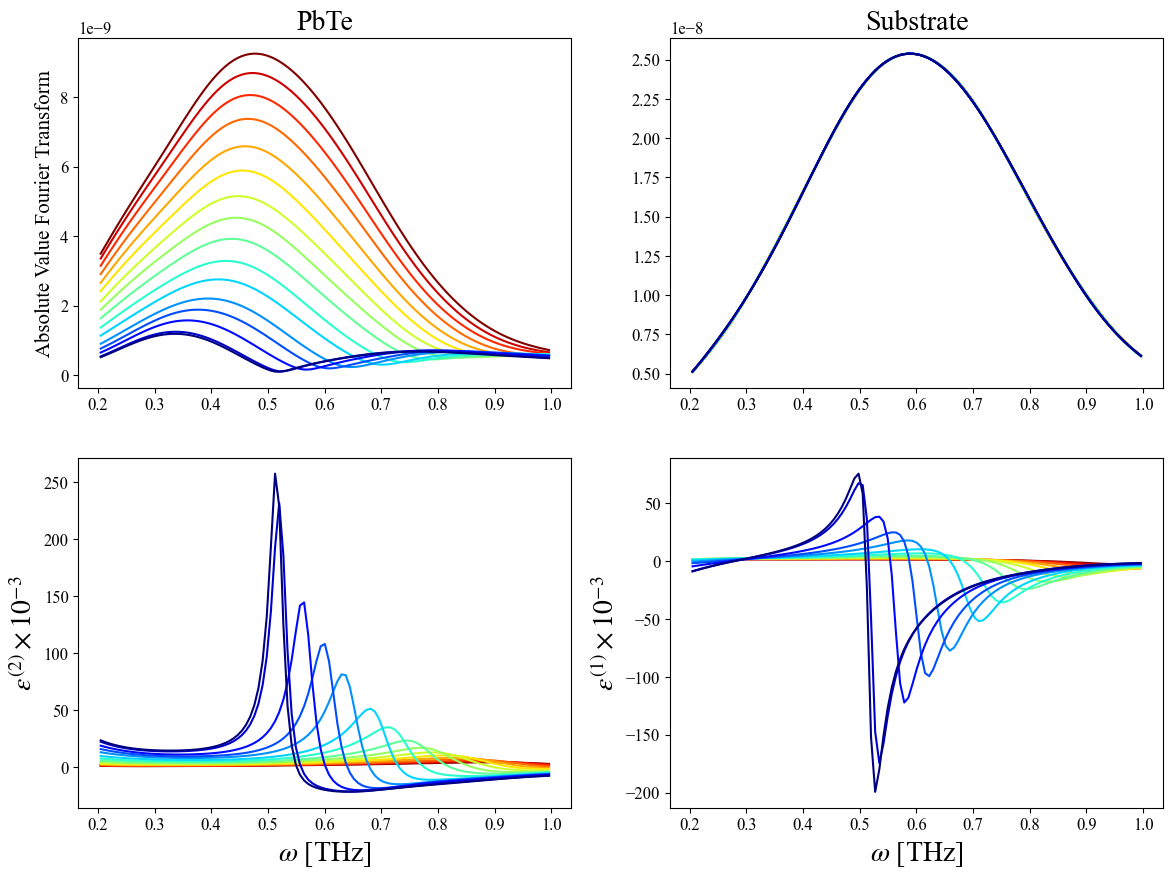

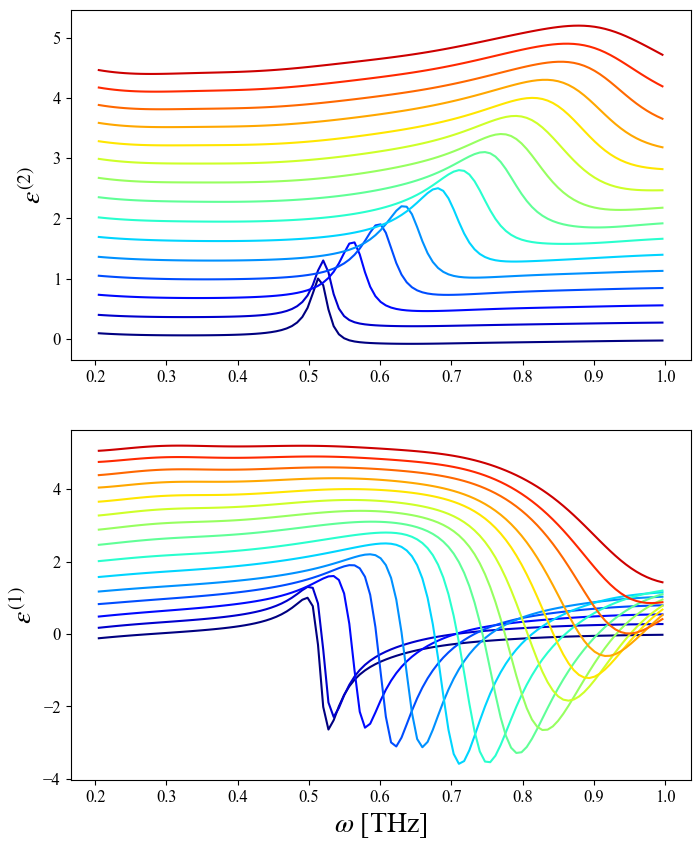

In [10]:
# Leer los archivos .dat
# f = plt.figure(figsize=(15,13))
permitivadade = []
temps = []
N = 2**12

fig = plt.figure(figsize=(14, 10))
for i,j in enumerate(archivos_ordenados_s[::-1]):

    try:

        path_signal = os.path.join(path_analisis,j)
        path_ref = os.path.join(path_analisis_ref ,archivos_ordenados_ref[0])
        temps.append(extraer_temperatura(path_signal))
        params_window = ['gaussian', 110]
        phase, y_signal_ventaneada, y_substrate_padding, ventana = getSignalWindowed(path_signal,path_ref,nk0,nk1,nk2,params_window)
        # Datos substrate
        y_subs_ventana = pd.Series(y_substrate_padding*ventana)
        y_signal_ventaneada = pd.Series(y_signal_ventaneada*ventana)

        
        k = 15
        nu = sp.fft.fftfreq(N, 1/30)
            # Aplicar ventana de Hamming a la señal
    
        # Transformada de Fourier de las señales
        fft_y_signal_ventaneada = FourierT(y_signal_ventaneada,N)[1:len(nu)//k]
        fft_y_subs_ventaneada = FourierT(y_subs_ventana,N)[1:len(nu)//k]

        # Filtrar las frecuencias
        nu = nu[1:len(nu)//k]
        xmin, xmax = 0.2, 1.0
        mask = (nu >= xmin) & (nu <= xmax)
        nu_filtradas = nu[mask]
        fft_y_signal_ventaneada = fft_y_signal_ventaneada[mask]
        fft_y_subs_ventaneada = fft_y_subs_ventaneada[mask]
        
        # phase = idx_max_signal-idx_max_substrate

        T_ventana = (fft_y_signal_ventaneada/fft_y_subs_ventaneada)*np.exp(2*np.pi*1j*nu_filtradas/c*(1-2.6)*delta_ls_corr)*np.exp(1j*2*np.pi*nu_filtradas*phase*1/30)
        n = 2.6
        ep_con = 1j*(1+n)*((1/T_ventana)-1)*c/(2*np.pi*nu_filtradas*0.0003)-n
        permitivadade.append(ep_con)


        plt.subplot(221)
        plt.plot(nu_filtradas, np.abs(fft_y_signal_ventaneada), label='FFT SIGNAL',color = colors[i])
        plt.ylabel('Absolute Value Fourier Transform',fontsize=15)
        plt.title('PbTe',fontsize=20)
        #plt.xlabel(r'$\nu$ [THz]',fontsize=15)
        #plt.legend()

        plt.subplot(222)
        plt.plot(nu_filtradas, np.abs(fft_y_subs_ventaneada), label='FFT SUBSTRATE',color = colors[i])
        plt.title('Substrate',fontsize=20)
        #plt.ylabel('Absolute Value Fourier Transform',fontsize=15)
        #plt.xlabel(r'$\nu$ [THz]',fontsize=15)
        # plt.legend()



        plt.subplot(223)
        plt.plot(nu_filtradas, np.imag(ep_con)*1e-3,color = colors[i])
        
        #plt.yscale('log')
        plt.ylabel(r'$\epsilon^{(2)}\times 10^{-3}$',fontsize=20)
        plt.xlabel(r'$\omega$ [THz]',fontsize=20)
        # plt.legend()
# 

        plt.subplot(224)
        plt.plot(nu_filtradas, np.real(ep_con)*1e-3, label='with window '+str(extraer_temperatura(archivos_ordenados_s[i]))+' K',color = colors[i])
        #plt.yscale('log')
        plt.ylabel(r'$\epsilon^{(1)}\times 10^{-3}$',fontsize=20)
        plt.xlabel(r'$\omega$ [THz]',fontsize=20)
        #plt.title(f'Delta sample real:{round(delta_ls[sample],4)}, Delta sample correg: {round(delta_ls_corr,5)}')
        #plt.legend()
  

        

    except:
        print(1)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8, 10))
offset = 0.3  # Desplazamiento vertical entre las curvas
cont = 0
for i in range(1,len(permitivadade),1):
    ep = permitivadade[-i]
    ax1.plot(nu_filtradas, np.imag(ep)/max(np.imag(ep)) + cont * offset, color=colors[-i], label=f'T: {round(temps[-i],3)} K')
    #ax1.set_xlabel(r'$\nu$ [THz]',fontsize=15)
    ax1.set_ylabel(r'$\epsilon^{(2)}$',fontsize=20)
    #ax1.set_title('Sample: '+sample)
    ax2.plot(nu_filtradas, np.real(ep)/max(np.real(ep)) + cont * offset, color=colors[-i], label=f'T: {round(temps[-i],3)} K')
    ax2.set_ylabel(r'$\epsilon^{(1)}$',fontsize=20)
    ax2.set_xlabel(r'$\omega$ [THz]',fontsize=20)
    #ax2.set_title('Sample: '+sample)
   # plt.legend(loc='upper right')
    cont+=1

# Fitting

In [26]:
# Create an independent variable with 100 measurements

initials_parameters = []

def anim2(index,ep_inf,ep_s,nu_to,Gamma,nu_p,gamma,borrar,add):


    permitivade_i = permitivadade[int(index)]

    # permitivade_i_real = np.real(permitivade_i)
    # permitivade_i_imag = np.imag(permitivade_i)
 

    p0 = [ep_inf,ep_s,nu_to,Gamma,nu_p,gamma]
    params = fit_complex_drude(nu_filtradas,permitivade_i,p0)

    yFit = epsilon_drude(nu_filtradas, *params)
    #print(poptBoth)

    # Plot the results
    plt.figure(figsize=(13, 4))

    plt.subplot(121)
    plt.plot(nu_filtradas, np.real(permitivade_i), "k.",label= str(extraer_temperatura(archivos_ordenados_s[int(index)]))+' K',color = colors[-int(index)] )
    #plt.plot(x, np.real(y), "r--", label="True y")
    plt.plot(nu_filtradas, np.real(yFit),'--k', label="Best fit")
    
    #plt.xlim(0.15,1.25)
    plt.ylabel('$\epsilon_{REAL}$',fontsize=20)
    #plt.ylim(-15000,15000)
    #plt.ylabel("Real part of y")
    plt.xlabel(r"$\nu$ $[THz]$")
    plt.legend()

    plt.subplot(122)
    
    #print(pico_maximo_x)
    # pico_maximo_y = np.imag(yNoisy)[pico_maximo_idx]
    plt.plot(nu_filtradas, np.imag(permitivade_i), "k.",label= str(extraer_temperatura(archivos_ordenados_s[int(index)]))+' K',color = colors[-int(index)] )
    plt.plot(nu_filtradas, np.imag(yFit),'--k',label="Best fit")
    # plt.plot(pico_maximo_x, pico_maximo_y , 'ro', label='Maximum')
    # #plt.plot(x, np.imag(y), "r--")
    
    # #print(np.imag(yFit))
    # plt.axhline(altura_media, color='gray', linestyle='--', label='Altura a media altura')
    plt.ylabel(r'$\epsilon_{IM}$',fontsize=20)
    plt.legend()
    #lt.xlim(0.15,1.25)f
    #plt.ylim(-2000,35000)

    plt.xlabel(r"$\nu$ $[THz]$")

    if int(borrar) ==1:
        initials_parameters.clear()
    if int(add) == 1:
        initials_parameters.append([params[0],params[1],params[2],params[3],params[4],params[5]])

    print(int(borrar))
    print(int(add))
    print(params)
    print(initials_parameters)



opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        index= widgets.FloatSlider(min=0,max=len(archivos_ordenados_s)-1,value=0,step=1,**opc),
        ep_inf= widgets.FloatSlider(min=0,max=30,value=5,step=0.1,**opc),
        ep_s= widgets.FloatSlider(min=0,max=30,value=20,step=0.1,**opc),
        nu_to= widgets.FloatSlider(min=0,max=2,value=0.5,step=0.1,**opc),
        Gamma= widgets.FloatSlider(min=0,max=50,value=20,step=0.1,**opc),
        nu_p= widgets.FloatSlider(min=0,max=100,value=20,step=0.1,**opc),
        gamma= widgets.FloatSlider(min=0,max=100,value=20,step=0.1,**opc),
        borrar= widgets.FloatSlider(min=0,max=1,value=0,step=1,**opc),
        add= widgets.FloatSlider(min=0,max=1,value=0,step=1,**opc),
        );



interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='index', max=15.0, readout_f…

# Parameters vs temperature

In [27]:
Temp = [extraer_temperatura(archivos_ordenados_s[i]) for i in range(len(archivos_ordenados_s))]

In [36]:
ep_inf,ep_s,nu_to,Gamma,nu_p,gamma = [],[],[],[],[],[]
#ep_inf,ep_s,nu_to,Gamma,nu_p,gamma = [],[],[],[]

for permit in permitivadade[::-1]: ##

    yNoisy = permit
    yReal = np.real(yNoisy)
    yImag = np.imag(yNoisy)
    params = fit_complex_drude(nu_filtradas,yNoisy)
    ep_inf.append(params[0])
    ep_s.append(params[1])
    nu_to.append(params[2])
    Gamma.append(params[3])
    nu_p.append(params[4])
    gamma.append(params[5])

temp_parameters, pcovBoth = curve_fit(T_crit,Temp,nu_to, maxfev=5000)

C:\Users\usuario_trabajo\AppData\Local\Temp\ipykernel_28708\4109879179.py:95: OptimizeWarning: Covariance of the parameters could not be estimated
  poptBoth, pcovBoth = curve_fit(epsilonboth_drude, np.hstack([x, x]), yBoth,maxfev=5000)


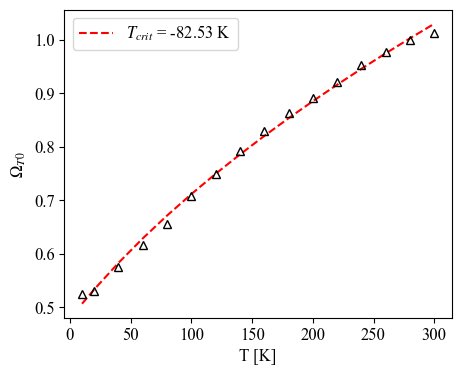

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))  # Tamaño ajustado
ax.plot(Temp,T_crit(Temp,*temp_parameters),'--r',label =r'$T_{crit}$ = ' +str(round(temp_parameters[1],2))+' K' )
ax.plot(Temp, nu_to, marker='^', color='black', linestyle='none', markerfacecolor='none')
    #ax.set_title(titles[i])
ax.set_xlabel('T [K]')
ax.set_ylabel(r'$\Omega_{T0}$ ')

# ax.set_ylabel(titles[i], fontweight='bold',fontsize=15)
ax.legend()

# Save data

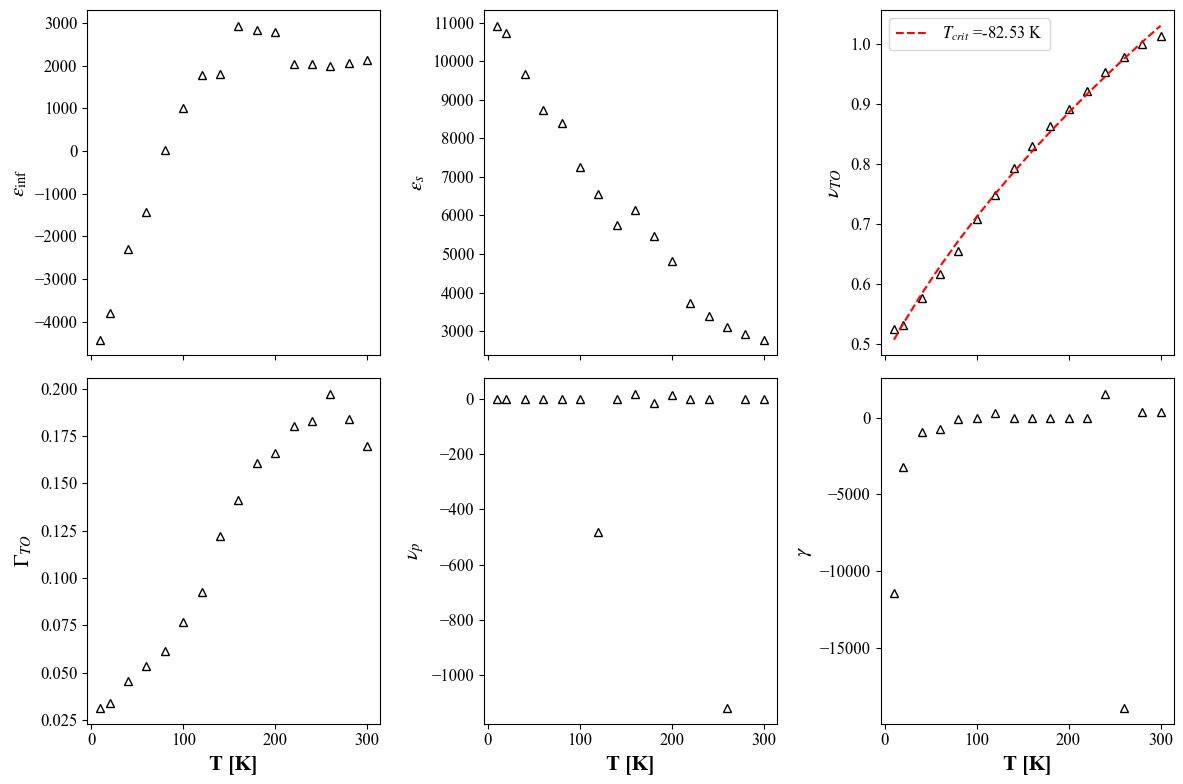

In [39]:
# Crear la figura y los ejes en una grilla 2x3
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # Tamaño ajustado

# Listas de los datos y títulos
y_data = [ep_inf, ep_s, nu_to, Gamma, nu_p, gamma]
titles = ['$\epsilon_{\inf}$', '$\epsilon_{s}$', r'$\nu_{TO}$', '$\Gamma_{TO}$', r'$\nu_p$', '$\gamma$']

# Iterar sobre los ejes y dibujar los gráficos
for i, ax in enumerate(axes.flat):
    #ax.plot(Temp[::-1], y_data[i], marker='^', color='black')
    ax.plot(Temp, y_data[i], marker='^', color='black', linestyle='none', markerfacecolor='none')
    #ax.set_title(titles[i])
    #ax.set_xlabel('x')
    ax.set_ylabel(titles[i], fontweight='bold',fontsize=15)

    if i==2:
        ax.plot(Temp,T_crit(Temp,*temp_parameters),'--r',label =r'$T_{crit}$ =' +str(round(temp_parameters[1],2))+' K' )
        ax.legend()
    if i <3:
        ax.set_xticklabels([])
    if i >= 3:  # Fila 2
        ax.set_xlabel('T [K]', fontweight='bold',fontsize=15)
    #ax.set_ylabel(titles[i])
    #ax.grid(True)  # Agregar grillas para mejor visualización

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()

# Mostrar la figura
plt.show()


In [88]:
# Crear un diccionario con los datos
data = {
    'Temp': Temp,
    'ep_inf': ep_inf,
    'ep_s': ep_s,
    'nu_to': nu_to,
    'Gamma': Gamma,
    'nu_p': nu_p,
    'gamma': gamma
}

# Crear un DataFrame
df = pd.DataFrame(data)

# Guardar en un archivo CSV con un nombre específico
nombre_archivo = sample
df.to_csv(nombre_archivo, index=False)

print(f"Archivo guardado como {nombre_archivo}")

Archivo guardado como 19012


# Plot 

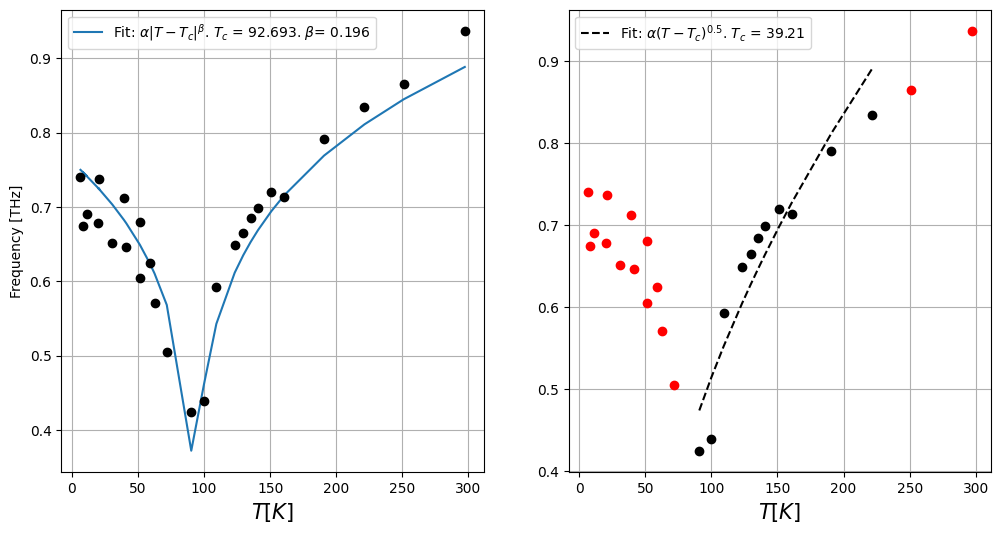

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x,a,b,t):
    return a*abs(x-t)**b


df = pd.read_csv('plot-data.csv')

# Suponiendo que el archivo tiene dos columnas llamadas 'Columna1' y 'Columna2'
# Si tus columnas tienen otros nombres, cámbialos aquí
x = df['x']
y = df.iloc[:, 1]


plt.figure(figsize=(12,6))


plt.subplot(121)
pp,cov = curve_fit(func,x,y,p0=[0.3,0.18,91])

plt.plot(x,func(x,*pp),label = r'Fit: $\alpha|T-T_{c}|^{\beta}$. $T_{c}$ = '+str(round(pp[-1],3))+r'. $\beta$= '+str(round(pp[1],3)))
plt.plot(x, y,'o', color='k')

# Etiquetas de los ejes
plt.xlabel('$T [K]$',fontsize=15)
plt.ylabel('Frequency [THz]')

# Título del gráfico
# plt.title('Gráfico de Columna 1 vs Columna 2')
plt.legend()
# Mostrar el gráfico
plt.grid(True)

# Crear el gráfico


# plt.plot(x1,func(x1,*pp),label = 'fit T>100. Crital exponent:'+str(round(pp[1],3)))
# plt.plot(x1, y1,'o', color='b')


# # Crear el gráfico

# def func2(x,a,b):
#     return a*abs(x-96.77)**b

# pp2,cov = curve_fit(func2,x2,y2)

# plt.plot(x2,func2(x2,*pp2),label = 'fit T<100. Crital exponent:'+str(round(pp[1],3)))
# plt.plot(x2, y2,'o', color='red')

def func2(x,a,t):
    return a*abs(x-t)**0.5

plt.subplot(122)
filter1 = (x > 85) & (x<250)

x1 = x[filter1]
y1 = y[filter1]

x2 = x[~filter1]
y2 = y[~filter1]
pp2,cov = curve_fit(func2,x1,y1)

plt.plot(x1,func2(x1,*pp2),'--k',label = r'Fit: $\alpha(T-T_{c})^{0.5}$. $T_{c}$ = '+str(round(pp2[-1],3)))
plt.plot(x1, y1,'o', color='k')
plt.plot(x2, y2,'o', color='r')

#plt.plot(x1,y1)

# Etiquetas de los ejes
plt.xlabel('$T [K]$',fontsize=15)
#plt.ylabel('Frequency [THz]')

# Título del gráfico
# plt.title('Gráfico de Columna 1 vs Columna 2')

# Mostrar el gráfico
plt.legend()
plt.grid(True)
plt.show()
